# <center>Machine Learning Lab: Exercise Sheet 7</center>
<center> <b>Submitted By: Mohit Bansal</b></center>
<center> <b>Student ID: 279314</b></center>

## Datasets
1. Classification Datasets: You can use one of the two datasets (or optionally, both datasets):

    (a) **Iris dataset D1**: Target attribute class: Iris Setosa, Iris Versicolour, Iris Virginica https://archive.ics.uci.edu/ml/datasets/Iris

    (b) **Wine Quality D2**: (use winequality-red.csv) http://archive.ics.uci.edu/ml/datasets/Wine+Quality
    
You are required to pre-process given datasets

In [78]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


# define column names
names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

# loading training data

path = '/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/WiSe 18/3101 Machine Learning/Excercises/Excercise 3'
os.chdir(path)
filename = 'iris.data'
irisDF = pd.read_csv(filename)
irisDF.head()


,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Exercise 1: Implement K-Nearest Neighbor (KNN) (10 Points)
Your task is to implement KNN algorithm. To implement KNN you have to:
+ **Split data into a train and a test split (70% and 30% respectively).**

In [139]:
# create design matrix X and target vector y
X = np.array(irisDF.ix[:, 0:4]) 	# end index is exclusive
y = np.array(irisDF['class ']) 	# another way of indexing a pandas df

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

print("Iris Dataset ----> Train Set:", len(X_train), "    Test Set: ", len(X_test))

Iris Dataset ----> Train Set: 105     Test Set:  45


+ **Implement a similarity (or a distance) measure. To begin with you can implement the Euclidean Distance**

For each point in the test set, we will calculate it's distance from each point in the training set and add it to a vector.

+ **Implement a function that returns top K Nearest Neighbors for a given query (data point).**

For each point in the test set, the vector is sorted and top K points are selected as nearest neighbour.

+ **You should provide the prediction for a given query (for a classification task you can use majority voting and for a regression you can use mean).**

Since IRIS is a classification dataset, we take the most common neighbour as the final prediction.

In [140]:
def predict(X_train, y_train, x_test, k):
    # create list for distances and targets
    distances = []
    targets = []

    for i in range(len(X_train)):
        # first we compute the euclidean distance
        distance = np.sqrt(np.sum(np.square(x_test - X_train[i, :])))
        # add it to list of distances
        distances.append([distance, i])

    # sort the list
    distances = sorted(distances)

    # make a list of the k neighbors' targets
    for i in range(k):
        index = distances[i][1]
        targets.append(y_train[index])

    # return most common target
    return Counter(targets).most_common(1)[0][0]

def kNearestNeighbor(X_train, y_train, X_test, k):
    predictions = []
    
    # loop over all observations
    for i in range(len(X_test)):
        predictions.append(predict(X_train, y_train, X_test[i, :], k))
    
    return np.asarray(predictions)

+ **Measure the quality of your prediction. [Hint: You have to choose a quality criterion according to the task you are solving i.e. a regression or a classification task Defend your choice].**

In [207]:
# making our predictions for k = 3
ytest_hat = kNearestNeighbor(X_train, y_train, X_test, k = 3)
accuracy = accuracy_score(y_test, ytest_hat) * 100
print('\nThe accuracy of our classifier is %2f%%' % accuracy)


The accuracy of our classifier is 95.555556%


Here, we used a simple accuracy score where,

$$Accuracy = \frac{correct-classifications}{total-observations}$$

We started with k = 3 and got a 95.56% accuracy on the test set which is pretty good given the small size of the dataset. This shows that the Iris dataset is highly homogenous in a multidimensional setting.

# Exercise 2: Optimize and Compare KNN algorithm. (10 Points)
### Part A: Determine Optimal Value of K in KNN algorithm. In this exercise you have to provide the optimal value of K for given datasets.
**1. How you can choose value of K for KNN. Give a criterion to choose an optimal value of K**

We can use *k-folds cross-validation with Grid-Search* technique to tune our hyperparameter K. 

**2. Implement the criterion for choosing the optimal value of K.**

+ We will divide our training set into k-folds (where k is different from K) 
+ For each value of k:
    + Use k-1 folds for training
    + Run the model on the last fold (validation set)
    + Calculate the accuracy score
    + Finally, average all the scores

The value of K which yeilds the highest accuracy (or lowest error) is the optimal value

In [221]:
from sklearn.model_selection import KFold

def kfold_Cross_Val(X, y, K, CV_splits = 10):
    # Define the split - into 10 folds by default
    kf = KFold(CV_splits) 

    fold_accuracy = []
    # For each fold
    for train_index, val_index in kf.split(X):
        # Create training and validation sets
        X_train_CV, X_val_CV = X[train_index], X[val_index]
        y_train_CV, y_val_CV = y[train_index], y[val_index]
        # Make prediction on validation set
        yval_hat_CV = kNearestNeighbor(X_train_CV, y_train_CV, X_val_CV, k = K)
        # Calculate accuracy
        fold_accuracy.append(accuracy_score(y_val_CV, yval_hat_CV))        
    # Average accuracy over all folds 
    return np.mean(fold_accuracy)
    
# creating list of K for KNN Grid-search
neighbors = list(range(1,20))  

# empty list that will hold cv scores
cv_scores = []

# For each K-value
for K in neighbors:
    # Get average accuracy over all folds
    accuracy = kfold_Cross_Val(X_train, y_train, K)
    cv_scores.append(accuracy)

In [222]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best K
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 10


In [223]:
# making our predictions on k = 10
ytest_hat = kNearestNeighbor(X_train, y_train, X_test, k = optimal_k)
accuracy = accuracy_score(y_test, ytest_hat) * 100
print('\nThe accuracy of our classifier is %2f%%' % accuracy)


The accuracy of our classifier is 97.777778%


So our accuracy has improved from 95.56% (k = 3) to 97.78% (k = 10) !

**3. Experimentally, give evidence that your chosen value is better than other values of K. [Hint: run your experiment with different values of K and plot the error measure for each value].**

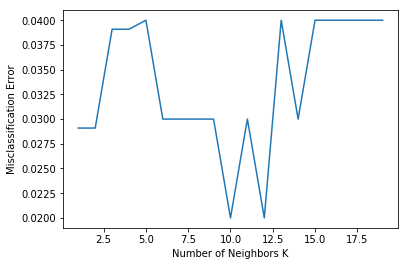

In [224]:
# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

So we can see that the error is least when k = 10 and 12. 

### Part B: Compare KNN algorithm with Tree based method. In this task you are allowed to use scikit learn. In particular you have to use Nearest Neighbor and Decision Tree implementation provided by scikit learn.

**1. You should be able to use Nearest Neighbor and Decision Tree provided by scikit learn to solve classification task for two datasets.**

**2. You have to provide the optimal hyperparameters for both the methods. [Hint: use Grid Search and cross validation and present results for them to support your solution].**

**3. Present the comparison of the two methods using evaluation results on test datasets. [Hint: Better to use cross validation to ascertain your results]**

In [250]:
from sklearn.neighbors import KNeighborsClassifier

# creating list of K for KNN 
neighbors = list(range(1,20))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    # Build model
    knn = KNeighborsClassifier(n_neighbors=k)
    # Get validation score for each model
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    # Get mean score for each k
    print('K-value', k, 'CROSS-VALIDATION SCORE: ', scores.mean())
    cv_scores.append(scores.mean())

optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print("\nThe optimal number of neighbors is %d" % optimal_k)

# making our predictions on optimal k
ytest_hat = kNearestNeighbor(X_train, y_train, X_test, k = optimal_k)
accuracy = accuracy_score(y_test, ytest_hat) * 100
print('\nThe accuracy of our classifier on the test set is %2f%%' % accuracy)

K-value 1 CROSS-VALIDATION SCORE:  0.9700000000000001
K-value 2 CROSS-VALIDATION SCORE:  0.9609090909090909
K-value 3 CROSS-VALIDATION SCORE:  0.9609090909090909
K-value 4 CROSS-VALIDATION SCORE:  0.970909090909091
K-value 5 CROSS-VALIDATION SCORE:  0.9800000000000001
K-value 6 CROSS-VALIDATION SCORE:  0.97
K-value 7 CROSS-VALIDATION SCORE:  0.97
K-value 8 CROSS-VALIDATION SCORE:  0.97
K-value 9 CROSS-VALIDATION SCORE:  0.97
K-value 10 CROSS-VALIDATION SCORE:  0.97
K-value 11 CROSS-VALIDATION SCORE:  0.9800000000000001
K-value 12 CROSS-VALIDATION SCORE:  0.97
K-value 13 CROSS-VALIDATION SCORE:  0.9700000000000001
K-value 14 CROSS-VALIDATION SCORE:  0.96
K-value 15 CROSS-VALIDATION SCORE:  0.95
K-value 16 CROSS-VALIDATION SCORE:  0.96
K-value 17 CROSS-VALIDATION SCORE:  0.95
K-value 18 CROSS-VALIDATION SCORE:  0.95
K-value 19 CROSS-VALIDATION SCORE:  0.95

The optimal number of neighbors is 5

The accuracy of our classifier on the test set is 97.777778%


Using the Cross-Validation inbuilt KNN Classifier in sklearn, we find that the optimal number of neighbors is 5. The classifier accuracy of 97.78% which is the best accuracy achieved from the previous results.

Let's now build a tree based classifier with **tree-depth** and **minimum split size** as our hyper parameters. Since our test set comprises only of 45 values, we will keep the depth between 2 & 6 and split size between 2 and 9.

In [254]:
from sklearn import tree

depth = list(range(2,7))
samples = list(range(2,10))

# empty list that will hold cv scores
cv_scores = []

for d in depth:
    for s in samples:
        clf = tree.DecisionTreeClassifier(max_depth = d, min_samples_split = s)
        clf = clf.fit(X_train, y_train)
        scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        # Get mean score for each combination
        print('DEPTH:', d, 'MIN_SAMPLES: ', s, 'CROSS-VALIDATION SCORE: ', scores.mean())

DEPTH: 2 MIN_SAMPLES:  2 CROSS-VALIDATION SCORE:  0.9309090909090909
DEPTH: 2 MIN_SAMPLES:  3 CROSS-VALIDATION SCORE:  0.9309090909090909
DEPTH: 2 MIN_SAMPLES:  4 CROSS-VALIDATION SCORE:  0.9309090909090909
DEPTH: 2 MIN_SAMPLES:  5 CROSS-VALIDATION SCORE:  0.9109090909090909
DEPTH: 2 MIN_SAMPLES:  6 CROSS-VALIDATION SCORE:  0.9309090909090909
DEPTH: 2 MIN_SAMPLES:  7 CROSS-VALIDATION SCORE:  0.9309090909090909
DEPTH: 2 MIN_SAMPLES:  8 CROSS-VALIDATION SCORE:  0.9309090909090909
DEPTH: 2 MIN_SAMPLES:  9 CROSS-VALIDATION SCORE:  0.9109090909090909
DEPTH: 3 MIN_SAMPLES:  2 CROSS-VALIDATION SCORE:  0.95
DEPTH: 3 MIN_SAMPLES:  3 CROSS-VALIDATION SCORE:  0.9400000000000001
DEPTH: 3 MIN_SAMPLES:  4 CROSS-VALIDATION SCORE:  0.95
DEPTH: 3 MIN_SAMPLES:  5 CROSS-VALIDATION SCORE:  0.9400000000000001
DEPTH: 3 MIN_SAMPLES:  6 CROSS-VALIDATION SCORE:  0.95
DEPTH: 3 MIN_SAMPLES:  7 CROSS-VALIDATION SCORE:  0.95
DEPTH: 3 MIN_SAMPLES:  8 CROSS-VALIDATION SCORE:  0.95
DEPTH: 3 MIN_SAMPLES:  9 CROSS-VALI

+ We see that depth of 3-5 and split size of 5-7 yeilds best results. 
+ Let's use (4, 5) as our combination for the test set.

In [253]:
clf = tree.DecisionTreeClassifier(max_depth = 4, min_samples_split = 5)
clf = clf.fit(X_train, y_train)
ytest_hat = clf.predict(X_test)
accuracy = accuracy_score(y_test, ytest_hat) * 100
print('\nThe accuracy of our classifier  on the test set is %2f%%' % accuracy)


The accuracy of our classifier  on the test set is 93.333333%


After running cross-validation to find best set of hyper-parameters for our KNN and Tree models respectively, we conclude that the KNN model had an overall higher accuracy than the tree based model. In a **KNN model** we tried to cluster similar (smaller distance) occurances together in a multidimensional space. This is a computation heavy task since it requires us to calculate distance between each observation. Therefore, for 100 observations we need to calculate 10,000 distance values. However, this also means that KNN can find the best possible solution to a problem since it has all the information before it starts the classification process.

A **tree based model** on the other hand, tries to maximize it's information gain at every step without knowing the final outcome. Therefore, it does not have the vision of KNN but is computationally much faster. This is useful when you have large amounts of data and do not require extremely high levels of accuracy.

Generally, in larger and noisier datasets, a tree model would be preferable to gain a general insight and learn segregation rules. However, in our case with 150 observations, KNN outperforms tree-based model because of the scarcity and homogenity of the data.

#### References:

+ Complete Guide to KNN with application in Python & R - https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/